# Modeling Pat Adoption with RandomForestClassifier

This notebook will use the Random Trees Algorithm for prediction of pet's adoption speed
- Metrics: Accuracy and Cohen's Weighted Kappa 
- Comparing model performance for cats and dogs combined vs. seperately. We will evaluate the overall accuracy for cats and dogs with 
  acc_combined_model = ((acc_cats * number_cats) + (acc_dogs * number_dogs))/(number_cats + number_dogs)

In [2]:
# importing necessary libraries and dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report, confusion_matrix

# import custom functions
from custom_functions import our_metrics, get_kappa, model_hyperparams

# display options
pd.set_option('display.max_rows', None)





# Import processed data - Cats and Dogs Combined

In [3]:
# import features
X_train = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_processed.csv')
X_test = pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_processed.csv')

# import target
y_train = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train.csv')
y_test = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test.csv')

# turn target df into 1D-array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()                  

# 

# Random Forest Default Model - Entire Data Set

In [14]:
# instantiate and fit the default RFC on all features
rf_def = RandomForestClassifier()
rf_def.fit(X_train, y_train)

# predict target
rf_def_y_train_pred = rf_def_all.predict(X_train)
rf_def_y_test_pred = rf_def_all.predict(X_test)

# Average number of nodes and depths of trees in the forest
n_nodes = []
depths = []

for single_tree in rf_def.estimators_:
    n_nodes.append(single_tree.tree_.node_count)
    depths.append(single_tree.tree_.max_depth)

print('__________________________________')
print(f'Average number of nodes in the forest: {int(np.mean(n_nodes))}')
print('__________________________________')
print(f'Average depth trees in the forest: {int(np.mean(depths))}')
print(' ')
print(' ')

model_hyperparams(rf_def)

__________________________________
Average number of nodes in the forest: 8153
__________________________________
Average depth trees in the forest: 28
 
 


,set hyperparams
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1


*** Model Evaluation: Predicting Train-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.9904
_____________________
Weighted Quadratic Kappa: 0.9918


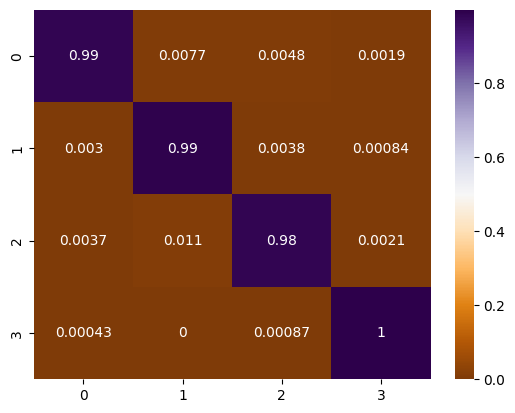

In [12]:
# Metrics predicting Train-Target
print('*** Model Evaluation: Predicting Train-Labels ***')
our_metrics(y_train, rf_def_y_train_pred)

*** Model Evaluation: Predicting Test-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.371
_____________________
Weighted Quadratic Kappa: 0.2478


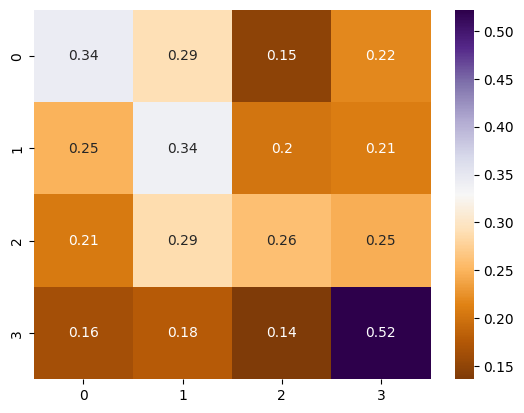

In [13]:
# Metrics predicting Test-Target
print('*** Model Evaluation: Predicting Test-Labels ***')
our_metrics(y_test, rf_def_y_test_pred)

# Random Forest Grid Search - Entire Data Set

In [18]:
X_test.columns

Index(['type', 'sterilized', 'breed_type', 'vaccinated_dewormed', 'fee_bin',
       'gender_0', 'gender_1', 'maturitysize_0', 'maturitysize_1',
       'maturitysize_2', 'maturitysize_3', 'furlength_0', 'furlength_1',
       'furlength_2', 'health_0', 'health_1', 'health_2', 'color_pattern_0',
       'color_pattern_1', 'color_pattern_2', 'photoamt_11', 'age_bin',
       'description_char'],
      dtype='object')

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [ ]:
# Hyperparameter grid based on hyperparameters of the default model:

# setting hyperparameter grid:
# I want to increase the number of estimators (aka trees in the forest) 
# and prevent overfitting by pruning the trees (min observations per split and per leaf)
param_grid = {
    'n_estimators': [500],
    'max_depth': [None] + list(np.linspace(10, 28, 18).astype(int)),
    'max_features': [None] + list(np.arange(1,5)),
    'min_samples_split': np.linspace(10, 100, 10).astype(int),
    'min_samples_leaf': np.linspace(5, 50, 10).astype(int),
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model for best accuracy_score and 50 fits:
random_found_forest = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit best model estimated by random search to train data:
random_found_forest.fit(X_train, y_train)

# Feature Importance

In [ ]:
features = X_train.columns.tolist()

# data frame with feature names and feature importance scores, sorted by importance
feature_importance = pd.DataFrame({'feature': features,
                   'importance': best_rs_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
# show 10 most important features
feature_importance.head(10)

NameError: name 'best_rs_model' is not defined